In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy import stats
from scipy.stats import t
import zipfile
from pathlib import Path
import os
import shutil

import joblib  # For saving the model


# Load the Data

In [ ]:
from google.colab import files

# Upload kaggle.json (your API token)
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"miss3persin","key":"195954e66e8429ca9aad405da9f6347b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c store-sales-time-series-forecasting


 23% 5.00M/21.4M [00:00<00:00, 50.0MB/s]
100% 21.4M/21.4M [00:00<00:00, 127MB/s] 


In [ ]:
# Extract the downloaded ZIP file
with zipfile.ZipFile("store-sales-time-series-forecasting.zip", 'r') as zip_ref:
    zip_ref.extractall("datasets/store_sales")

# Load the data into pandas DataFrames
train_df = pd.read_csv(Path("datasets/store_sales/train.csv"))
test_df = pd.read_csv(Path("datasets/store_sales/test.csv"))

# Quick look at the train data
print(train_df.head())
print(train_df.info())


   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

drive_path = "/content/drive/MyDrive/store_sales_dataset"

# Create the folder if it doesn't exist
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

# Move the dataset to Google Drive
shutil.move("/content/datasets/store_sales", drive_path)

print(f"Dataset saved to {drive_path}")

KeyboardInterrupt: 

In [ ]:
os.listdir(drive_path)

['store_sales']

In [ ]:
# Load train and test datasets from Google Drive
train_df = pd.read_csv(f"{drive_path}/store_sales/train.csv")
test_df = pd.read_csv(f"{drive_path}/store_sales/test.csv")

# Verify the loaded data
print(train_df.head())
print(test_df.head())


   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0


# A closer look at the data

In [ ]:
print(train_df.head())

   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0


In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


In [ ]:
print(train_df.describe())

                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02


In [ ]:
# Check for any missing values
missing_values = train_df.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [ ]:
# Check the unique values in store_nbr and family columns
print("Unique stores:", train_df['store_nbr'].nunique())
print("Unique product families:", train_df['family'].nunique())

# Display the first few unique values of 'family'
print("All product families:", train_df['family'].unique())


Unique stores: 54
Unique product families: 33
Sample product families: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [ ]:
train_df['family'].value_counts()

,count
family,
AUTOMOTIVE,90936
HOME APPLIANCES,90936
SCHOOL AND OFFICE SUPPLIES,90936
PRODUCE,90936
PREPARED FOODS,90936
POULTRY,90936
PLAYERS AND ELECTRONICS,90936
PET SUPPLIES,90936
PERSONAL CARE,90936


# Create a test set

In [ ]:
# def split_train_test(data, test_ratio=0.2):
#     np.random.seed(42)  # Seed for reproducibility
#     shuffled_indices = np.random.permutation(len(data))
#     test_size = int(len(data) * test_ratio)
#     test_indices = shuffled_indices[:test_size]
#     train_indices = shuffled_indices[test_size:]
#     return data.iloc[train_indices], data.iloc[test_indices]

# train_set, test_set = split_train_test(df)

# Data exploration (visualizing trends)

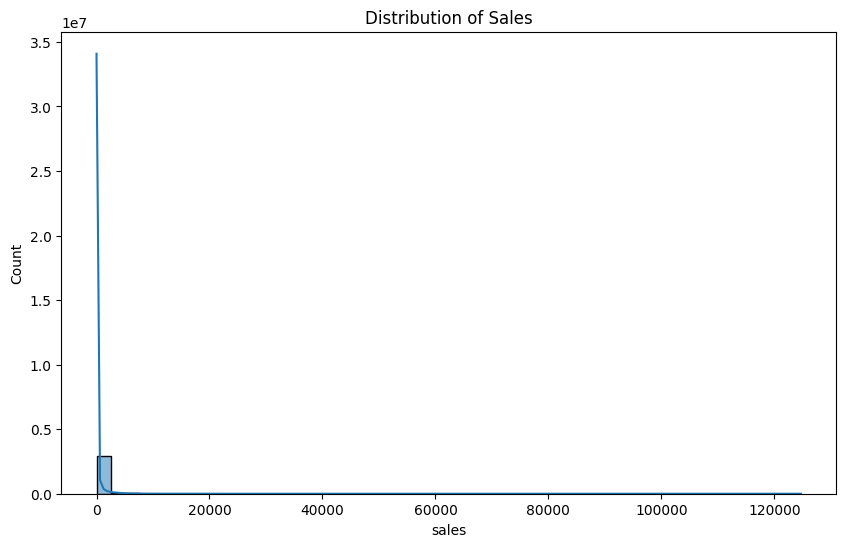

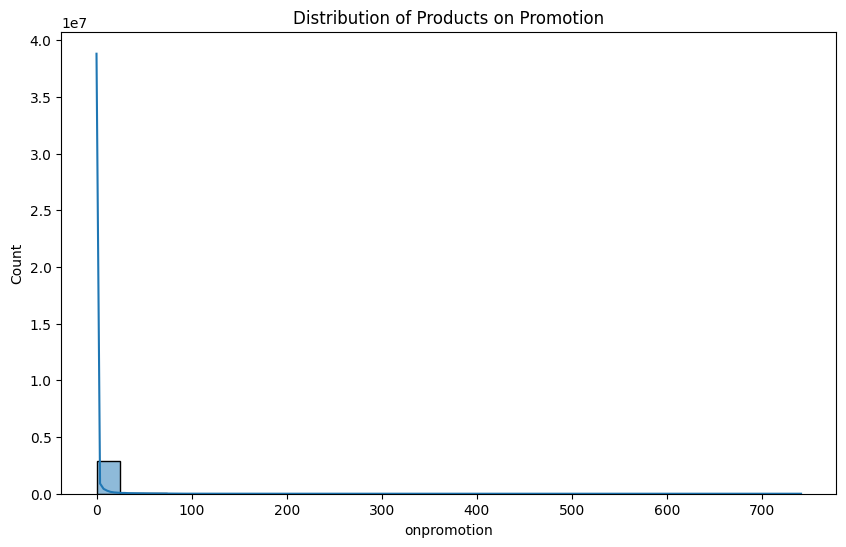

<ipython-input-18-5eae52968c48>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_families.index, x=top_families.values, palette="viridis")


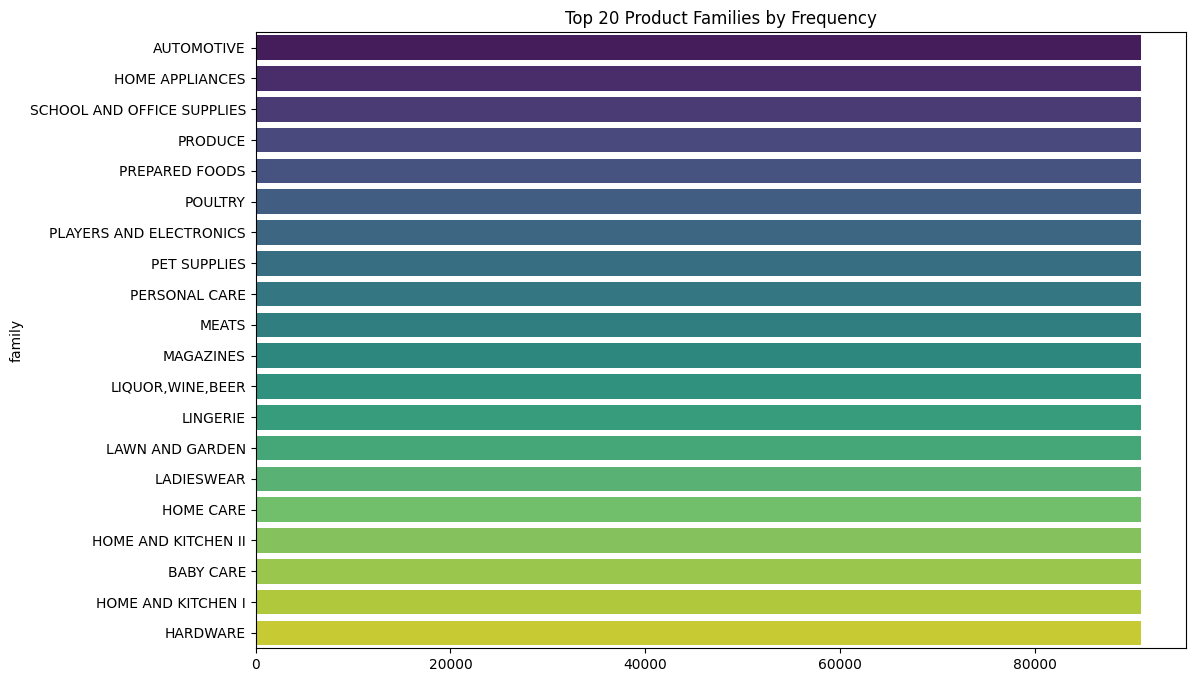

In [ ]:
# Distribution of sales
plt.figure(figsize=(10, 6))
sns.histplot(train_df['sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.show()

# Distribution of products on promotion
plt.figure(figsize=(10, 6))
sns.histplot(train_df['onpromotion'], bins=30, kde=True)
plt.title("Distribution of Products on Promotion")
plt.show()

# Frequency of product families (Top 20)
plt.figure(figsize=(12, 8))
top_families = train_df['family'].value_counts().nlargest(20)
sns.barplot(y=top_families.index, x=top_families.values, palette="viridis")
plt.title("Top 20 Product Families by Frequency")
plt.show()

# Correlation analysis
# Correlation matrix
correlation_matrix = train_df[['sales', 'onpromotion']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between Numerical Features")
plt.show()


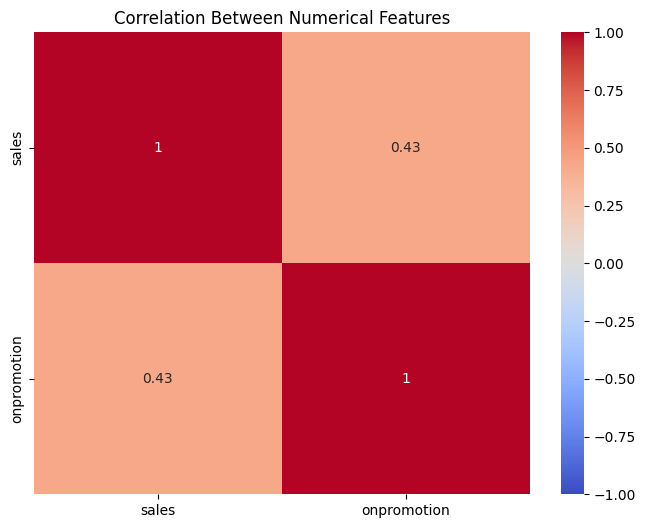

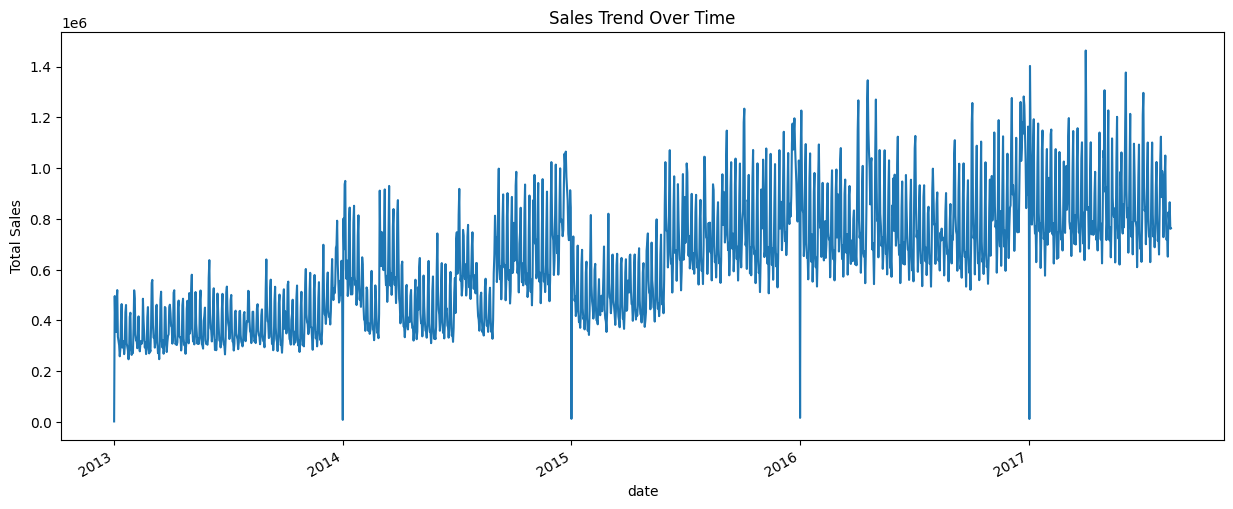

In [ ]:
# Convert 'date' column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])

# Group by date and sum sales
sales_per_day = train_df.groupby('date')['sales'].sum()

# Plot sales trend over time
plt.figure(figsize=(15, 6))
sales_per_day.plot()
plt.title("Sales Trend Over Time")
plt.ylabel("Total Sales")
plt.show()


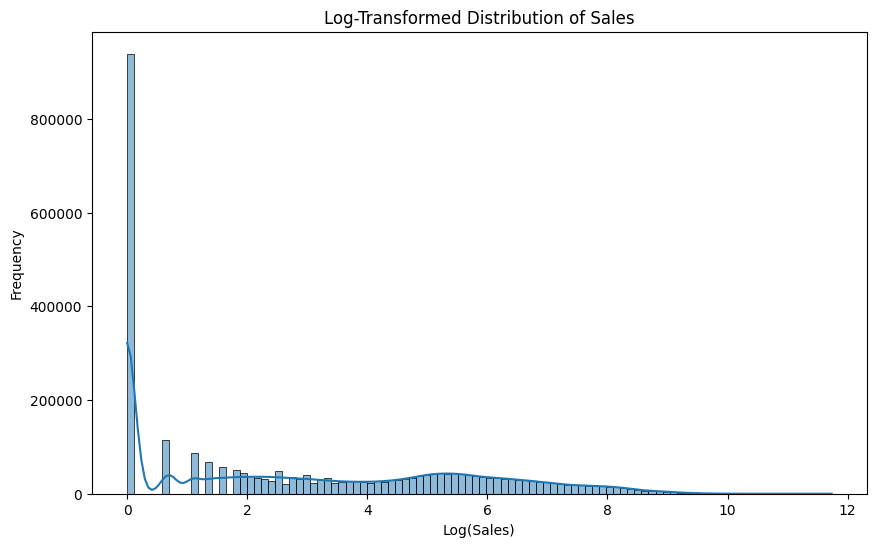

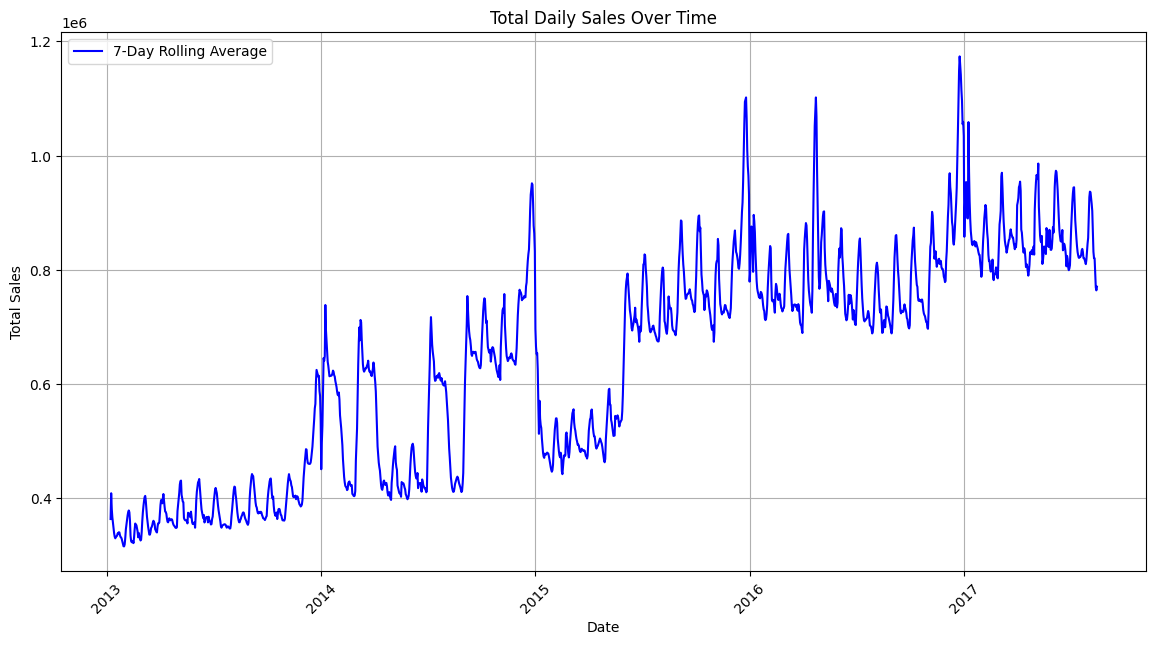

In [ ]:
# Log-transform sales for better visualization
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(train_df['sales']), bins=100, kde=True)
plt.title('Log-Transformed Distribution of Sales')
plt.xlabel('Log(Sales)')
plt.ylabel('Frequency')
plt.show()

# Group by date and sum sales
daily_sales = train_df.groupby('date')['sales'].sum().reset_index()

# Calculate a rolling average
daily_sales['rolling_sales'] = daily_sales['sales'].rolling(window=7).mean()

plt.figure(figsize=(14, 7))
plt.plot(daily_sales['date'], daily_sales['rolling_sales'], color='blue', label='7-Day Rolling Average')
plt.title('Total Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()



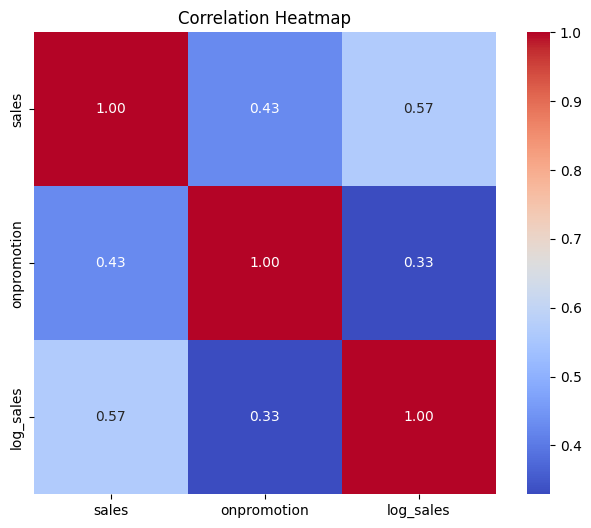

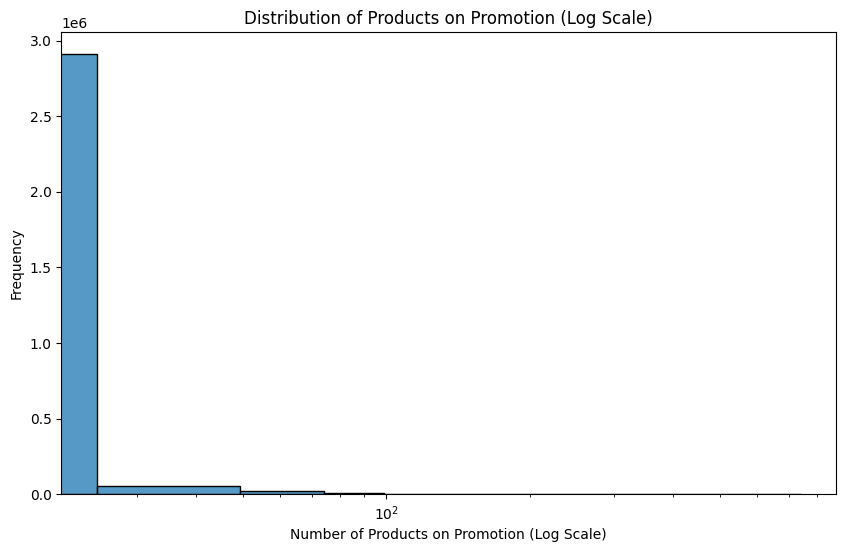

In [ ]:
# Create a new column for log-transformed sales
train_df['log_sales'] = np.log1p(train_df['sales'])

# Include log_sales in correlation calculation
correlation_matrix = train_df[['sales', 'onpromotion', 'log_sales']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(train_df['onpromotion'], bins=30)
plt.xscale('log')  # Using log scale for the x-axis
plt.title('Distribution of Products on Promotion (Log Scale)')
plt.xlabel('Number of Products on Promotion (Log Scale)')
plt.ylabel('Frequency')
plt.show()

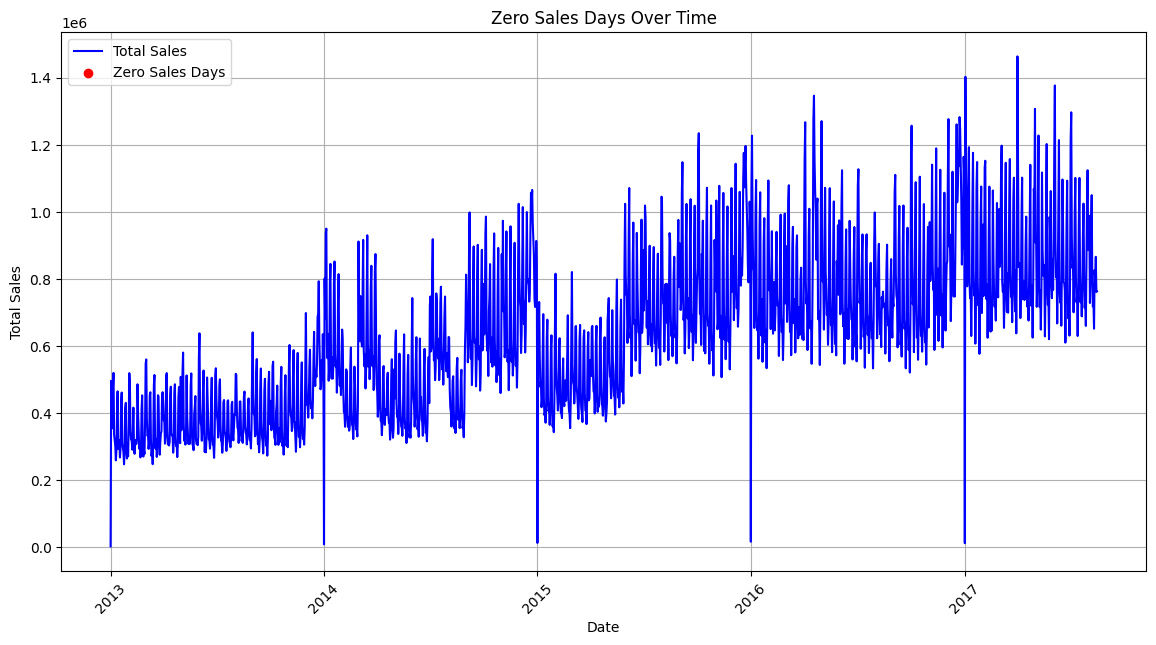

In [ ]:
# Create a DataFrame for zero sales days
zero_sales_days = daily_sales[daily_sales['sales'] == 0]

plt.figure(figsize=(14, 7))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Total Sales', color='blue')
plt.scatter(zero_sales_days['date'], zero_sales_days['sales'], color='red', label='Zero Sales Days')
plt.title('Zero Sales Days Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Data Preparation (Data Cleaning, Feature Engineering)

In [ ]:
# Load the training data
train_df = pd.read_csv(f"{drive_path}/store_sales/train.csv")

# Data Cleaning
# Remove duplicates
train_df.drop_duplicates(inplace=True)

# Convert 'date' column to datetime, might redo this again later
train_df['date'] = pd.to_datetime(train_df['date'])

# Outlier detection (using Z-score for sales)
z_scores = np.abs(stats.zscore(train_df['sales']))
train_df = train_df[(z_scores < 3)]  # Keeping records with Z-score < 3

# Check categorical variables
train_df['family'] = train_df['family'].astype('category')

# Investigate zero sales days (optional, depending on your analysis)
zero_sales_days = train_df[train_df['sales'] == 0]


In [ ]:
# Feature Engineering
# Extract date features
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['day_of_week'] = train_df['date'].dt.dayofweek
train_df['is_weekend'] = train_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Create lag features (e.g., sales from the previous day)
train_df['lag_sales'] = train_df.groupby(['store_nbr', 'family'], observed=True)['sales'].shift(1)

# Promotional indicators
train_df['promo_flag'] = train_df['onpromotion'].apply(lambda x: 1 if x > 0 else 0)

# One-hot encoding for 'family' column
train_df = pd.get_dummies(train_df, columns=['family'], drop_first=True)

# Aggregate features for stores
store_avg_sales = train_df.groupby('store_nbr')['sales'].mean().reset_index()
store_avg_sales.columns = ['store_nbr', 'avg_sales']
train_df = train_df.merge(store_avg_sales, on='store_nbr', how='left')

# Check the final dataframe
print(train_df.head())

<ipython-input-28-7d69c93ff5ca>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df['lag_sales'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1)


   id       date  store_nbr  sales  onpromotion  year  month  day  \
0   0 2013-01-01          1    0.0            0  2013      1    1   
1   1 2013-01-01          1    0.0            0  2013      1    1   
2   2 2013-01-01          1    0.0            0  2013      1    1   
3   3 2013-01-01          1    0.0            0  2013      1    1   
4   4 2013-01-01          1    0.0            0  2013      1    1   

   day_of_week  is_weekend  ...  family_MEATS  family_PERSONAL CARE  \
0            1           0  ...         False                 False   
1            1           0  ...         False                 False   
2            1           0  ...         False                 False   
3            1           0  ...         False                 False   
4            1           0  ...         False                 False   

   family_PET SUPPLIES  family_PLAYERS AND ELECTRONICS  family_POULTRY  \
0                False                           False           False   
1         

# EDA Visualizations

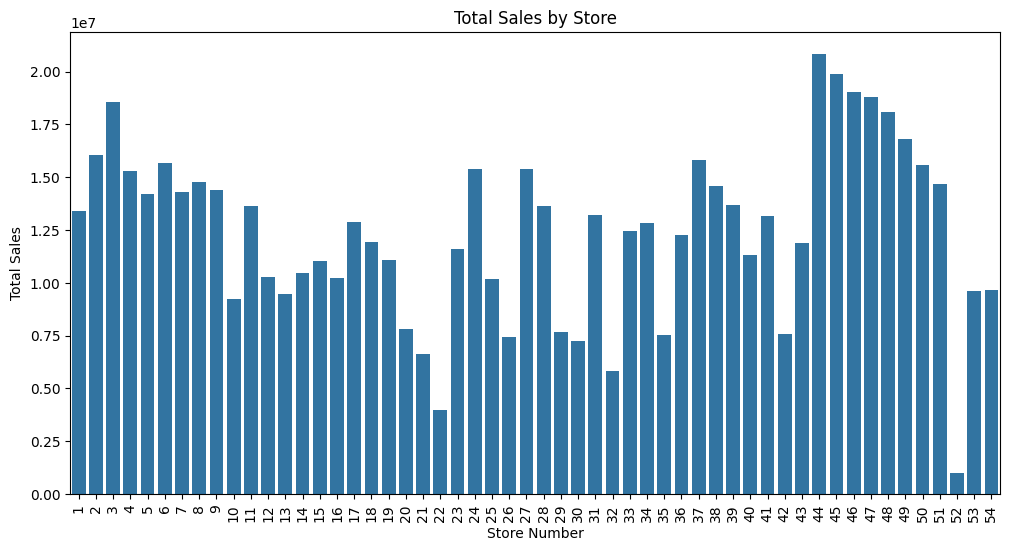

In [ ]:
# Sales Distribution by Store
plt.figure(figsize=(12, 6))
store_sales = train_df.groupby('store_nbr')['sales'].sum().sort_values(ascending=False)
sns.barplot(x=store_sales.index, y=store_sales.values)
plt.title('Total Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()


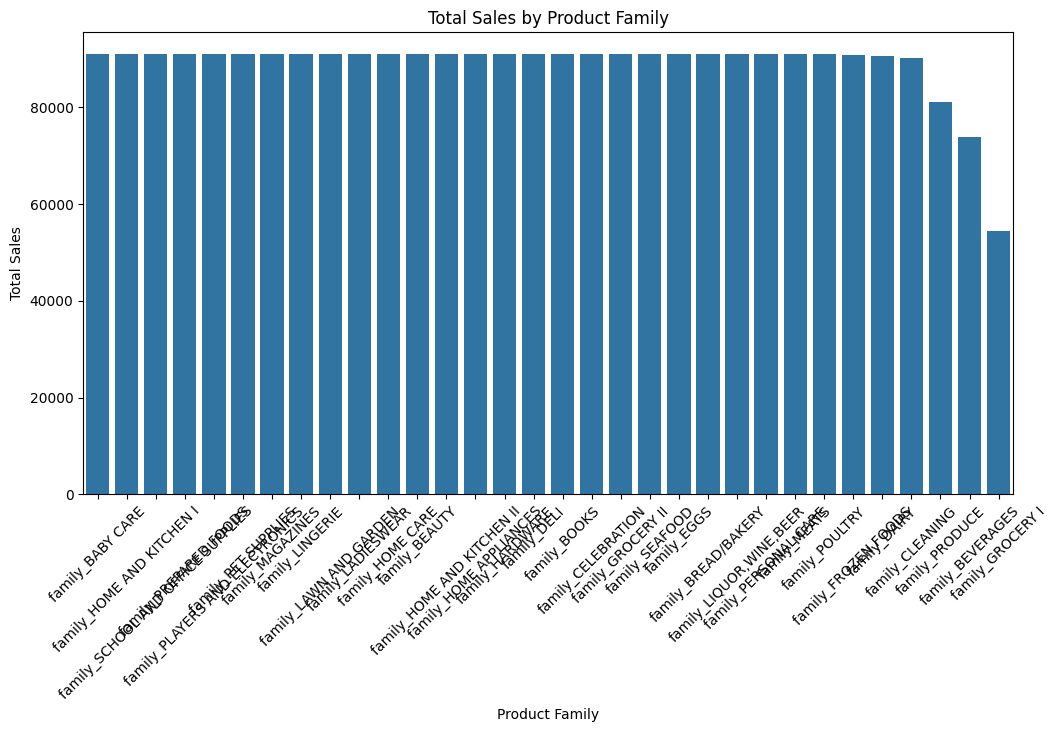

In [ ]:
# Sales Distribution by Product Family

#'family' columns are prefixed with 'family_'
family_sales = train_df.filter(like='family_').sum()
family_sales = family_sales.sort_values(ascending=False)

# Plotting the adjusted family sales
plt.figure(figsize=(12, 6))
sns.barplot(x=family_sales.index, y=family_sales.values)
plt.title('Total Sales by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


<Figure size 1400x700 with 0 Axes>

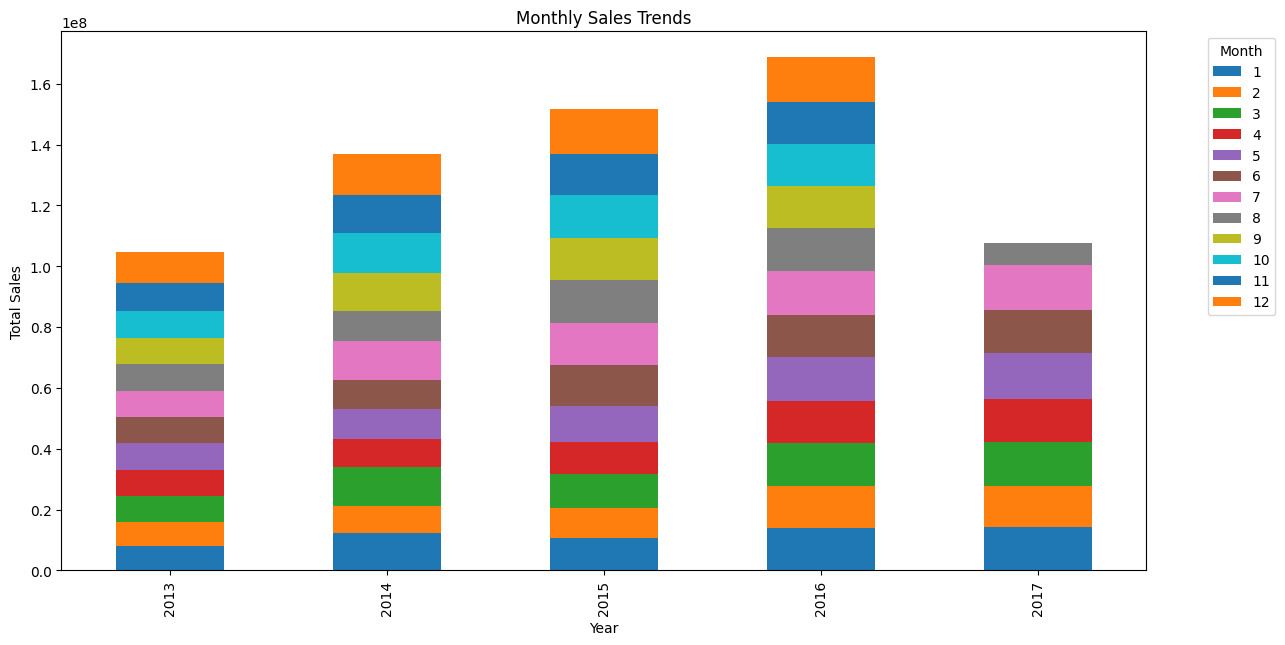

In [ ]:
# Sales Trends by Month and Year
plt.figure(figsize=(14, 7))
monthly_sales = train_df.groupby(['year', 'month'])['sales'].sum().unstack()
monthly_sales.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Monthly Sales Trends')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


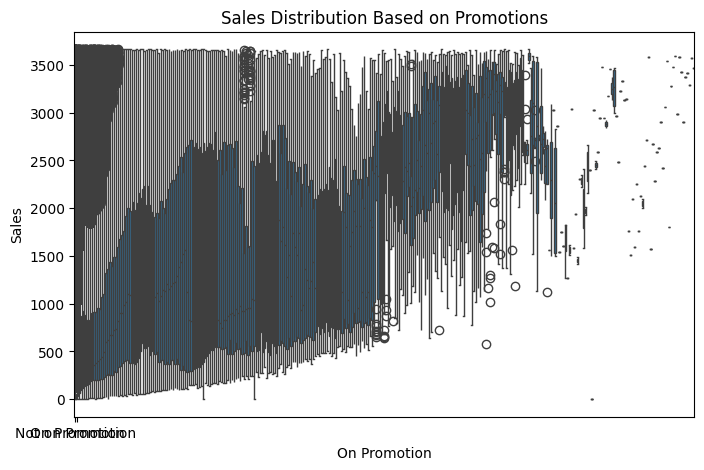

In [ ]:
# Impact of Promotions on Sales
plt.figure(figsize=(8, 5))
sns.boxplot(x='onpromotion', y='sales', data=train_df)
plt.title('Sales Distribution Based on Promotions')
plt.xlabel('On Promotion')
plt.ylabel('Sales')
plt.xticks([0, 1], ['Not on Promotion', 'On Promotion'])
plt.show()


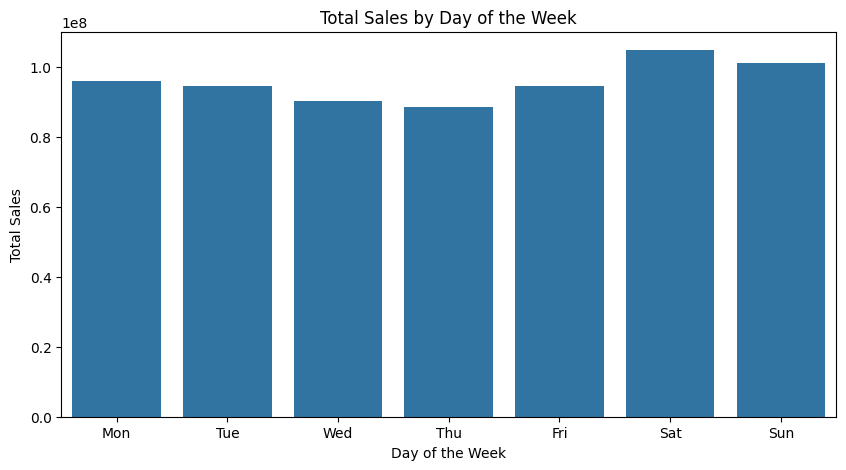

In [ ]:
# Sales by Day of the Week
plt.figure(figsize=(10, 5))
weekday_sales = train_df.groupby('day_of_week')['sales'].sum()
sns.barplot(x=weekday_sales.index, y=weekday_sales.values)
plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


# More Data Preparation (Categorical Encoding, Scaling)

In [ ]:
# Convert 'date' column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Extract useful date features
for df in [train_df, test_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)  # Weekend indicator

# Take the first 10,000 rows for training
X_train = train_df.drop(columns=['sales', 'date']).iloc[:10000]
y_train = train_df['sales'].iloc[:10000]

# Keep the full test set
X_test = test_df.drop(columns=['date'])

# Identify categorical and numeric features
categorical_features = ['store_nbr', 'family']
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Create a pipeline for each model
models = {
    "Linear Regression": Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())]),
    "Random Forest": Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor(verbose=1))]),
    "Gradient Boosting": Pipeline(steps=[('preprocessor', preprocessor), ('model', GradientBoostingRegressor(verbose=1))])
}



# Train and Evaluate Models

In [ ]:
# for model_name, model in models.items():
#     print(f"Training {model_name}...")
#     model.fit(X_train, y_train)

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    print(f"{name} training completed.\n")


# Evaluating the Models
results = {}

for model_name, model in models.items():
    # Predicting on the training data for evaluation
    y_pred = model.predict(X_train)

    # Evaluate performance using training data
    mae = mean_absolute_error(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    results[model_name] = {
        "MAE": mae,
        "MSE": mse,
        "R²": r2
    }

# Display results
results_df = pd.DataFrame(results).T
print(results_df)

Training Linear Regression...
Linear Regression training completed.

Training Random Forest...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    8.3s


Random Forest training completed.

Training Gradient Boosting...
      Iter       Train Loss   Remaining Time 
         1      438462.4938            1.18s
         2      393854.0485            1.09s
         3      357579.3475            1.03s
         4      328096.9652            1.01s
         5      304092.3826            0.99s
         6      283963.3195            0.98s
         7      267408.3331            0.96s
         8      250724.7778            0.95s
         9      238751.2858            0.94s
        10      227216.8923            0.93s
        20      165358.6571            0.79s
        30      140682.5022            0.68s
        40      127464.4223            0.58s
        50      118822.8900            0.49s
        60      110700.5787            0.39s
        70      103367.9336            0.29s
        80       96762.3788            0.19s
        90       92369.4804            0.10s
       100       88149.0354            0.00s
Gradient Boosting training complet

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


# Fine-tuning with GridSearchCV

In [ ]:
# # Split the original train_df into training and validation sets
# X_train_full = train_df.drop(columns=['sales', 'date'])
# y_train_full = train_df['sales']

# # 80% train, 20% validation split
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_full, y_train_full, test_size=0.2, random_state=42
# )

# # Create the Random Forest pipeline
# rf_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),  # Preprocessing step
#     ('model', RandomForestRegressor(random_state=42, n_jobs=-1))  # Model step
# ])

# # Define the hyperparameters grid for RandomForestRegressor
# param_grid = {
#     'model__n_estimators': [200, 300],       # Try more trees
#     'model__max_depth': [None, 10, 20],      # Depth of each tree
#     'model__min_samples_split': [2, 5],      # Min samples to split
#     'model__min_samples_leaf': [1, 2],       # Min samples at a leaf node
#     'model__max_features': ['sqrt', 'log2', None]  # Valid options only
# }

# # Initialize GridSearchCV with the pipeline
# grid_search = GridSearchCV(
#     estimator=rf_pipeline,
#     param_grid=param_grid,
#     cv=5,                   # More folds for better evaluation
#     n_jobs=-1,              # Use all CPU cores
#     verbose=2,              # Show progress
#     scoring='neg_mean_absolute_error',  # Minimize MAE
#     error_score='raise'  # Raise errors to debug immediately
# )

# # Train on a subset of the data (first 10,000 samples)
# grid_search.fit(X_train[:10000], y_train[:10000])

# # Get the best model and parameters
# best_rf_model = grid_search.best_estimator_
# print("Best Hyperparameters:", grid_search.best_params_)

# # Evaluate the tuned model on the validation set
# y_pred = best_rf_model.predict(X_val)

# # Calculate evaluation metrics
# mae = mean_absolute_error(y_val, y_pred)
# mse = mean_squared_error(y_val, y_pred)
# r2 = r2_score(y_val, y_pred)

# # Print the results
# print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters: {'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
MAE: 121.09, MSE: 216647.72, R²: 0.8257


# Evaluate on the Test Set

In [ ]:
# # Use only the first 10,000 records from the training data
# X_train_10k = X_train.iloc[:10000]
# y_train_10k = y_train.iloc[:10000]

# # Split into train and validation sets
# X_train_final, X_valid, y_train_final, y_valid = train_test_split(
#     X_train_10k, y_train_10k, test_size=0.2, random_state=42
# )

# # Fit the model on the reduced training data
# best_rf_model.fit(X_train_final, y_train_final)

# # Predict on the validation set
# y_valid_pred = best_rf_model.predict(X_valid)

# # Evaluate the model on the validation set
# val_mae = mean_absolute_error(y_valid, y_valid_pred)
# val_mse = mean_squared_error(y_valid, y_valid_pred)
# val_r2 = r2_score(y_valid, y_valid_pred)

# print(f"Validation MAE: {val_mae:.2f}, MSE: {val_mse:.2f}, R²: {val_r2:.4f}")


Validation MAE: 134.70, MSE: 270258.25, R²: 0.7902


In [ ]:
# # Predict on the first 5 test records
# X_test_first5 = X_test.iloc[:5]
# y_test_pred_first5 = best_rf_model.predict(X_test_first5)

# # Compare predictions with actual sales (from the original dataset)
# comparison_df = test_df.iloc[:5].copy()  # Copy to avoid modifying the original
# comparison_df['predicted_sales'] = y_test_pred_first5

# # Print the comparison
# print(comparison_df[['date', 'store_nbr', 'family', 'sales', 'predicted_sales']])


# Reverting to Pre-tuned Model

In [ ]:
# 1. Define the pre-tuned Random Forest model
pre_tuned_rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Ensure scaling and encoding are applied
    ('model', RandomForestRegressor(
        n_estimators=100,    # Default value or set your earlier one
        max_depth=None,      # No depth limit
        random_state=42,     # Ensure reproducibility
        n_jobs=-1,           # Utilize all CPU cores
        verbose=1            # Show progress
    ))
])

# 2. Train the pre-tuned Random Forest model on the first 10,000 records
X_train_subset = X_train.iloc[:10000]
y_train_subset = y_train.iloc[:10000]

pre_tuned_rf_model.fit(X_train_subset, y_train_subset)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.3s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['id', 'store_nbr',
                                                   'onpromotion',
                                                   'is_weekend']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['store_nbr', 'family'])])),
                ('model',
                 RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1))])

In [ ]:
# 1. Select the first 5 records from the training dataset
X_test_first5 = X_train.iloc[:5]
y_test_first5 = y_train.iloc[:5]  # This is just for comparison; not strictly necessary.

# 2. Predict the sales for these first 5 records
y_test_pred_first5 = pre_tuned_rf_model.predict(X_test_first5)

# 3. Create a comparison DataFrame for the first 5 predictions
comparison_df = X_test_first5.copy()
comparison_df['predicted_sales'] = y_test_pred_first5

# Optionally, add actual sales for comparison
comparison_df['actual_sales'] = y_test_first5.values

print(comparison_df)

              id  store_nbr          family  onpromotion  year  month  day  \
2902383  2902383         45      AUTOMOTIVE            2  2017      6   21   
1651514  1651514         47  PREPARED FOODS            0  2015      7   18   
1948349  1948349         26  PREPARED FOODS            0  2016      1    2   
2893871  2893871          7          BEAUTY            1  2017      6   16   
2867501  2867501         16         SEAFOOD            0  2017      6    2   

         day_of_week  is_weekend  predicted_sales  actual_sales  
2902383            2           0        18.620000        13.000  
1651514            5           1       330.110791       325.525  
1948349            5           1        11.572990         4.000  
2893871            4           0         6.880000         5.000  
2867501            4           0         3.420000         4.000  


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
# 1. Select the first 10,000 records from the training dataset for evaluation
X_test_subset = X_train.iloc[:10000]
y_test_subset = y_train.iloc[:10000]  # This is for calculating metrics

# 2. Predict the sales for these first 10,000 records
y_test_pred_subset = pre_tuned_rf_model.predict(X_test_subset)

# 3. Calculate performance metrics
mae = mean_absolute_error(y_test_subset, y_test_pred_subset)
mse = mean_squared_error(y_test_subset, y_test_pred_subset)
r2 = r2_score(y_test_subset, y_test_pred_subset)

# 4. Print evaluation metrics
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s


MAE: 45.34, MSE: 26468.26, R²: 0.9778


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.0s finished


In [ ]:
# # Select the first 10,000 records from the training set
# X_train_subset = X_train[:10000]
# y_train_subset = y_train[:10000]

# # Create a pipeline for the Random Forest model
# pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor(n_estimators=300))])

# # Define the number of folds for cross-validation
# cv_folds = 5

# # Perform cross-validation on the subset
# cv_scores = cross_val_score(pipeline, X_train_subset, y_train_subset, cv=cv_folds, scoring='neg_mean_absolute_error')

# # Convert negative MAE to positive
# cv_mae = -cv_scores

# # Print cross-validation results
# print(f"Cross-Validated MAE for {cv_folds} folds on first 10,000 records: {cv_mae}")
# print(f"Mean Cross-Validated MAE: {np.mean(cv_mae):.2f} ± {np.std(cv_mae):.2f}")

Cross-Validated MAE for 5 folds on first 10,000 records: [106.56764185 131.52195324 128.28348745 137.15367228 141.90754726]
Mean Cross-Validated MAE: 129.09 ± 12.19


# Confidence Interval for Generalization Error

In [ ]:
# confidence = 0.95
# squared_errors = (final_predictions - y_test) ** 2
# mean = squared_errors.mean()
# m = len(squared_errors)
# interval = t.interval(confidence, m - 1, loc=mean, scale=np.sqrt(squared_errors.var() / m))
# print(f"95% confidence interval for generalization error: {interval}")

# Save the Model

In [ ]:
# Save the model to a file
joblib.dump(pre_tuned_rf_model, 'pre_tuned_rf_model.joblib')
print("Model saved as 'pre_tuned_rf_model.joblib'")


Model saved as 'pre_tuned_rf_model.joblib'


# Load and Use the Model

In [ ]:
# Load the model from the file
loaded_rf_model = joblib.load('pre_tuned_rf_model.joblib')
print("Model loaded successfully")



Model loaded successfully


# Usage

In [ ]:
def get_user_input():
    # Gather input from the user
    store_nbr = int(input("Enter store number: "))
    family = input("Enter product family: ")
    onpromotion = int(input("Is the product on promotion? (1 for Yes, 0 for No): "))
    date = input("Enter date (YYYY-MM-DD): ")

    # Convert date to datetime and extract features
    date = pd.to_datetime(date)
    year = date.year
    month = date.month
    day = date.day
    day_of_week = date.dayofweek
    is_weekend = int(day_of_week >= 5)  # Saturday and Sunday are weekends

    # Create a DataFrame to match the input shape for the model
    input_data = pd.DataFrame({
        'id': [0],  # Placeholder for 'id'
        'store_nbr': [store_nbr],
        'family': [family],
        'onpromotion': [onpromotion],
        'year': [year],
        'month': [month],
        'day': [day],
        'day_of_week': [day_of_week],
        'is_weekend': [is_weekend]
    })

    return input_data

# Main function to predict
def main():
    # Get user input
    user_input = get_user_input()

    # Make predictions using the pre-tuned Random Forest model
    prediction = pre_tuned_rf_model.predict(user_input)

    # Display the prediction
    print(f"Predicted sales: {prediction[0]:.2f}")

if __name__ == "__main__":
    main()


Enter store number: 1
Enter product family: AUTOMOTIVE
Is the product on promotion? (1 for Yes, 0 for No): 0
Enter date (YYYY-MM-DD): 2013-01-01
Predicted sales: 3.45


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
